# Install and import libraries

In [5]:
!pip install pytorch-tabular==1.1.1 torchmetrics==1.4.0 --quiet

In [ ]:
!pip install shap==0.45.1 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.3/544.3 kB 32.7 MB/s eta 0:00:00


In [6]:
!pip install optuna --quiet

In [1]:
import pandas as pd
import numpy as np
import kagglehub
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from pytorch_tabular import TabularModel
from pytorch_tabular.config import DataConfig, TrainerConfig, OptimizerConfig, ExperimentConfig
from pytorch_tabular.models import NodeConfig
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import numpy as np
import torch
from sklearn.utils.class_weight import compute_class_weight
from pytorch_tabular.utils.nn_utils import OOMException
import optuna
from sklearn.metrics import recall_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
data_path = path + "/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(data_path)
clear_output()

# Checking the imbalance

In [11]:
df['Churn'].value_counts(normalize = True)*100

,proportion
Churn,
No,73.463013
Yes,26.536987


The distribution shows a little imbalance, which we should focus on it later

# Pre-processing

*   Delete the useless columns that cannot be generalized
*   Rename the columns for better representation



In [3]:
useless_cols = [
    'customerID'#, 'PhoneService', 'MultipleLines',
    #'InternetService', 'StreamingTV', 'StreamingMovies',
    #'TechSupport', 'OnlineSecurity', 'DeviceProtection'
]
rename_map = {
  'tenure':          'subscription_tenure_months',
  'Contract':        'billing_cycle_type',
  'MonthlyCharges':  'MonthlyCharges',
  'TotalCharges':    'TotalCharges',

  'InternetService': 'PlanType',
  'PhoneService':    'ProductEnabled',
  #'MultipleLines':   'has_multiple_seats',

  #'OnlineSecurity':  'addon_security_enabled',
  'OnlineBackup':    'OnlineBackup',
  #'DeviceProtection':'addon_monitoring_enabled',
  #'TechSupport':     'support_tier',
  'StreamingTV':     'FeatureA',
  'StreamingMovies': 'FeatureB',

  #'PaperlessBilling':'PaperlessBilling',
  'PaymentMethod':   'PaymentMethod',

  'SeniorCitizen':   'is_senior_user',
  'Partner':         'has_partner',
  'Dependents':      'has_dependents',
}
existing = [c for c in useless_cols if c in df.columns]
df = df.drop(columns=existing)
rename_map_existing = {k: v for k, v in rename_map.items() if k in df.columns}
df = df.rename(columns=rename_map_existing)
df.head()

,gender,is_senior_user,has_partner,has_dependents,subscription_tenure_months,ProductEnabled,MultipleLines,PlanType,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,FeatureA,FeatureB,billing_cycle_type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Clean the TotalCharge column by converting it into a numerical values

In [4]:
if 'TotalCharges' in df.columns:
  df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
  df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
  clear_output()
  print("TotalCharges Column fixed and filled")

TotalCharges Column fixed and filled


#### Target mapping and Data splitting

In [5]:
y = df['Churn'].map({'No': 0, 'Yes': 1}).astype('int64')
X = df.drop(columns=['Churn'])

X_train_full, X_test, y_train_full, y_test = train_test_split(
  X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
  X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

#### Merges the feature matrices (X_train, X_val, X_test) with their corresponding labels (y_train, y_val, y_test)

In [6]:
target_col = "Churn"

train_df = X_train.copy()
train_df[target_col] = y_train.values

val_df = X_val.copy()
val_df[target_col] = y_val.values

test_df = X_test.copy()
test_df[target_col] = y_test.values

In [7]:
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()

# Default model

For experimental reasons, we train the default model on our dataset

In [ ]:
# DataConfig
data_config = DataConfig(
    target=["Churn"],
    continuous_cols=num_cols,
    categorical_cols=cat_cols,
)

# TrainerConfig
trainer_config = TrainerConfig(
    max_epochs=10,
    load_best=False,
    accelerator="auto",
    devices=1,
)

# OptimizerConfig defaults (optimizer="Adam", lr=1e-3, weight_decay=0.0)
optimizer_config = OptimizerConfig()

# NODE defaults (num_layers=1, num_trees=128, depth=6, input_dropout=0.0, additional_tree_output_dim=0, bin_function="entmoid15", choice_function="entmax15")
model_config = NodeConfig(task="classification")

# Enable logging
experiment_config = ExperimentConfig(
    project_name="tb_logs",
    run_name="node_10_epochs",
    log_target="tensorboard",
)

# Build model
tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    experiment_config=experiment_config,
    verbose=False,
    suppress_lightning_logger=True,
)

tabular_model.fit(train=train_df, validation=val_df)


/usr/local/lib/python3.12/dist-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ NODEBackbone     │  1.1 M │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 2 │ _head            │ Lambda           │      0 │ train │
│ 3 │ loss             │ CrossEntropyLoss │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 769                                                                                          
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 24                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

In [ ]:
# Save model
tabular_model.save_model("saved_models/mode_default_model")
print("Saved to: node_prod_model/")

Saved to: node_prod_model/


#### Test the model on the test data

In [ ]:
pred_df = tabular_model.predict(test_df)
pred_df.head()

/usr/local/lib/python3.12/dist-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

,Churn_0_probability,Churn_1_probability,Churn_prediction
437,0.912961,0.087039,0
2280,0.361781,0.638219,1
2235,0.931783,0.068217,0
4460,0.634341,0.365659,0
3761,0.947477,0.052523,0


### Evaluation

In [ ]:
y_true = test_df["Churn"].values
y_pred = pred_df["Churn_prediction"].values

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.64      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409



As the result shows, the model struggles to detect the churn customers ( 52% recall)

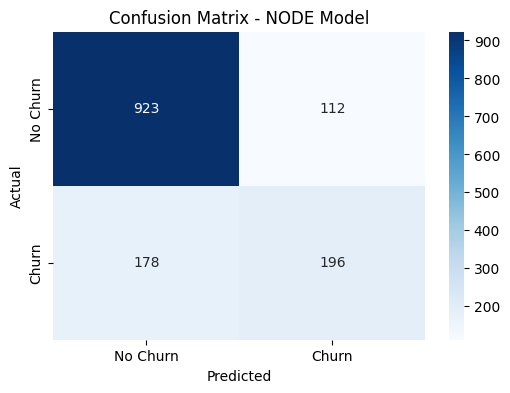

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - NODE Model")
plt.show()


As mentioned above, the model is missing many churn customers

In [ ]:
y_true = test_df["Churn"].values
y_prob = pred_df["Churn_1_probability"].values   # probability of class 1 (Churn)

In [ ]:
auc = roc_auc_score(y_true, y_prob)
print("ROC-AUC Score:", auc)

ROC-AUC Score: 0.8383244206773618


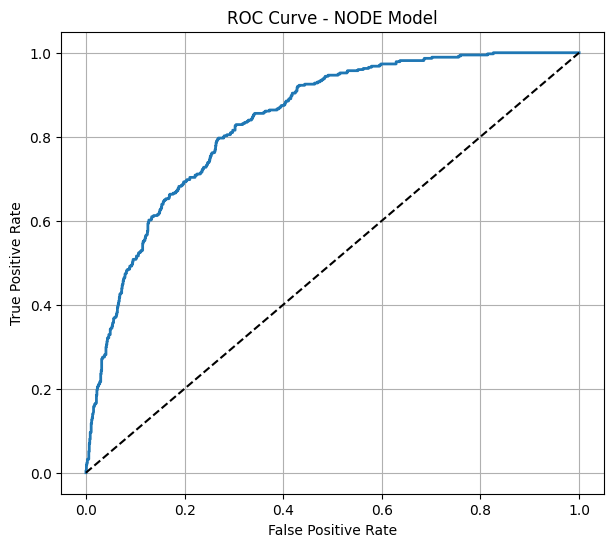

In [ ]:
# compute ROC curve points
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

# plot ROC
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], "k--")   # diagonal baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - NODE Model")
plt.grid(True)
plt.show()

The model exhibits strong discriminative ability, despite having a moderate recall for class 1. This confirms that the model knows how to separate churners, but the chosen threshold (0.5) may not be optimal for catching more of them

# Fixing imbalance using class weight

Since the dataset has a little imbalanced, we will experiment using the class weight on the default model to check how it performed

In [ ]:
# DataConfig
data_config = DataConfig(
    target=["Churn"],
    continuous_cols=num_cols,
    categorical_cols=cat_cols,
)

# TrainerConfig
trainer_config = TrainerConfig(
    max_epochs=10,
    load_best=False,
    accelerator="auto",
    devices=1,
)

# OptimizerConfig
optimizer_config = OptimizerConfig()

# NODE default config
model_config = NodeConfig(task="classification")

# Logging for curves
experiment_config = ExperimentConfig(
    project_name="tb_logs",
    run_name="node_10_epochs",
    log_target="tensorboard",
)

# Build model
tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    experiment_config=experiment_config,
    verbose=False,
    suppress_lightning_logger=True,
)

# CLASS WEIGHTS
y_train_np = train_df["Churn"].values
classes = np.array([0, 1])

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_np
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# weighted loss
weighted_loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

print("Class weights:", class_weights) # result: Class weights: [0.68061009 1.88419732]

# Train
tabular_model.fit(
    train=train_df,
    validation=val_df,
    loss=weighted_loss
)

Class weights: [0.68061009 1.88419732]


/usr/local/lib/python3.12/dist-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │  1.1 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 769                                                                                          
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 24                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

In [ ]:
# Save model
tabular_model.save_model("saved_models/mode_default_model_With_CLassWeight")
print("Saved to: node_prod_model/")

Saved to: node_prod_model/


#### Test the model on the test data

In [ ]:
pred_df = tabular_model.predict(test_df)
pred_df.head()

/usr/local/lib/python3.12/dist-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

,Churn_0_probability,Churn_1_probability,Churn_prediction
437,0.821262,0.178738,0
2280,0.180907,0.819093,1
2235,0.844403,0.155597,0
4460,0.370314,0.629686,1
3761,0.876588,0.123412,0


### Evaluations

In [ ]:
y_true = test_df["Churn"].values
y_pred = pred_df["Churn_prediction"].values

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.78      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.75      0.76      1409



The class weight successfully helped the model by reducing the issue of missing churn customers

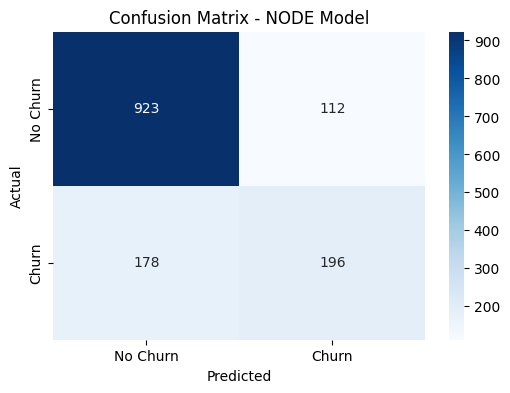

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - NODE Model")
plt.show()

The model now predicts Churn more frequently, as the confusion matrix shows that it is better at detecting churners, which matches the improved recall (0.78)

In [ ]:
y_true = test_df["Churn"].values
y_prob = pred_df["Churn_1_probability"].values   # probability of class 1 (Churn)

In [ ]:
auc = roc_auc_score(y_true, y_prob)
print("ROC-AUC Score:", auc)

ROC-AUC Score: 0.8366813919243586


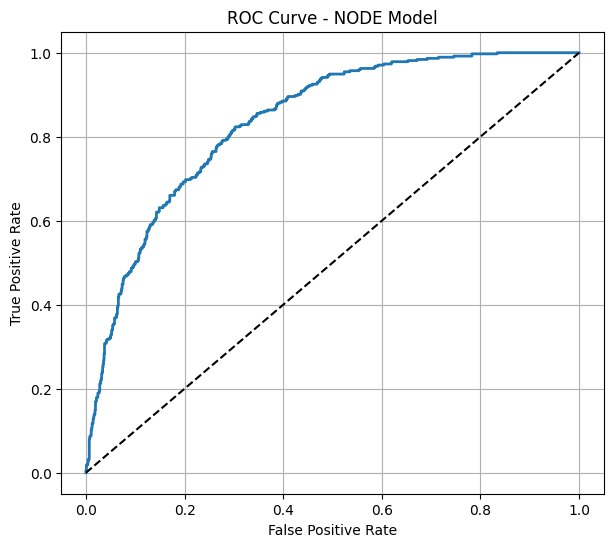

In [ ]:
# compute the curve points
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

# plot it
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], "k--")   # diagonal baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - NODE Model")
plt.grid(True)
plt.show()

The ROC curve remains clearly above the diagonal baseline, indicating that the model still has a strong ability to distinguish between churn and non-churn cases across different thresholds

# Tune threshold

Another method to solve imbalanced dataset, it to fine tune the threshold. So, we will check which it the best threshold and use it for the inference stage -Using the previous model which is with the class weight-

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

# Get predictions
pred_df = tabular_model.predict(val_df)

# The probability column
prob_col = "Churn_1_probability"

# Extract probabilities and true labels
y_probs = pred_df[prob_col].values
y_true = val_df["Churn"].values  # must be 0/1

/usr/local/lib/python3.12/dist-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

In [ ]:
# Scan thresholds (0.10 → 0.89)
thresholds = [i/100 for i in range(10, 90)]
results = []

for t in thresholds:
    preds = (y_probs >= t).astype(int)

    precision = precision_score(y_true, preds, zero_division=0)
    recall = recall_score(y_true, preds, zero_division=0)
    f1 = f1_score(y_true, preds, zero_division=0)

    results.append((t, precision, recall, f1))

In [ ]:
# Print results
for r in results:
    print(f"Threshold={r[0]:.2f}  Precision={r[1]:.3f}  Recall={r[2]:.3f}  F1={r[3]:.3f}")

# Best threshold by F1
best = max(results, key=lambda x: x[3])
print("\nBest threshold based on F1:")
print(f"Threshold={best[0]:.2f}, Precision={best[1]:.3f}, Recall={best[2]:.3f}, F1={best[3]:.3f}")


Threshold=0.10  Precision=0.310  Recall=0.990  F1=0.472
Threshold=0.11  Precision=0.325  Recall=0.990  F1=0.489
Threshold=0.12  Precision=0.333  Recall=0.990  F1=0.499
Threshold=0.13  Precision=0.341  Recall=0.987  F1=0.507
Threshold=0.14  Precision=0.347  Recall=0.987  F1=0.514
Threshold=0.15  Precision=0.354  Recall=0.980  F1=0.520
Threshold=0.16  Precision=0.358  Recall=0.973  F1=0.523
Threshold=0.17  Precision=0.359  Recall=0.963  F1=0.523
Threshold=0.18  Precision=0.364  Recall=0.957  F1=0.528
Threshold=0.19  Precision=0.374  Recall=0.957  F1=0.538
Threshold=0.20  Precision=0.379  Recall=0.957  F1=0.543
Threshold=0.21  Precision=0.383  Recall=0.950  F1=0.546
Threshold=0.22  Precision=0.389  Recall=0.943  F1=0.551
Threshold=0.23  Precision=0.399  Recall=0.943  F1=0.561
Threshold=0.24  Precision=0.401  Recall=0.926  F1=0.560
Threshold=0.25  Precision=0.405  Recall=0.916  F1=0.561
Threshold=0.26  Precision=0.412  Recall=0.916  F1=0.568
Threshold=0.27  Precision=0.415  Recall=0.903  F

### Evaluation

In [ ]:
y_true = test_df["Churn"].values
y_prob = pred_df["Churn_1_probability"].values   # prob of class 1

In [ ]:
best_threshold = 0.58 #Specify the best threshold
y_pred = (y_prob >= best_threshold).astype(int)

In [ ]:
pred_df = tabular_model.predict(test_df)
pred_df.head()

/usr/local/lib/python3.12/dist-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fillna(self._imputed, inplace=True)
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

,Churn_0_probability,Churn_1_probability,Churn_prediction
437,0.821262,0.178738,0
2280,0.180907,0.819093,1
2235,0.844403,0.155597,0
4460,0.370314,0.629686,1
3761,0.876588,0.123412,0


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1035
           1       0.54      0.70      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.76      0.77      1409



As the recall decreases slightly compared to the previous model (0.70 vs 0.78), the precision improves (0.54 vs 0.51). This results in fewer false positives while still detecting significantly more churners than the default model</n>

***Best balance between catching churners and avoiding false alarms***

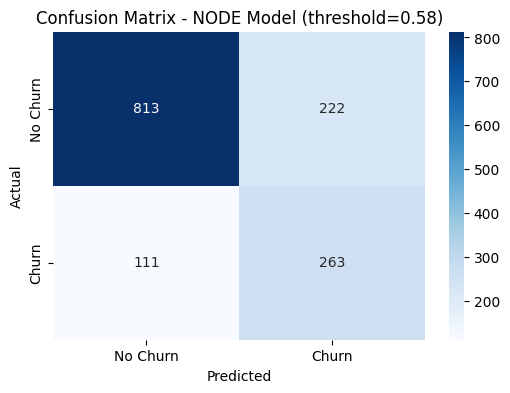

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - NODE Model (threshold=0.58)")
plt.show()

Using a threshold of 0.58 gives a balanced performance

In [ ]:
auc = roc_auc_score(y_true, y_prob)
print("ROC-AUC Score:", auc)

ROC-AUC Score: 0.8366813919243586


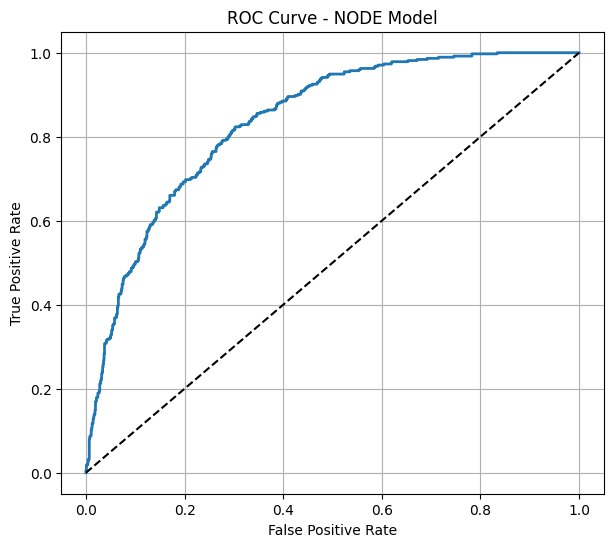

In [ ]:
# compute ROC curve points
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

# plot ROC
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], "k--")   # diagonal baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - NODE Model")
plt.grid(True)
plt.show()

The ROC curve remains clearly above the diagonal baseline, indicating that the model keeps a strong ability to distinguish between churners and non-churners regardless of the threshold

# Hyper parameter tuning (Bayesian)

To improve the model performance, we will use Hyper parameter tuning using Bayesian optimization. We will tune architectural and training parameters such as learning_rate, num_layers, depth, batch_size, max_epochs, and layer_dim.

#### Applying Class Weights to Handle Class Imbalance

In [8]:
y_train_np = train_df["Churn"].values
classes = np.array([0, 1])

class_weights = compute_class_weight("balanced", classes=classes, y=y_train_np)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

weighted_loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
print("Class weights:", class_weights)

Class weights: [0.68061009 1.88419732]


The search space includes parameters that control the model architecture, training dynamics, and regularization, which allows Optuna to test many architectural variations and training configurations, enabling the model to discover the combination that yields the highest recall for churn customers

In [9]:
def objective(trial):

    # Search space
    lr = trial.suggest_float("lr", 1e-4, 3e-3, log=True)

    num_layers = trial.suggest_int("num_layers", 1, 3)
    depth      = trial.suggest_int("depth", 4, 7)
    num_trees  = trial.suggest_int("num_trees", 64, 256, step=64)

    layer_dim      = trial.suggest_int("layer_dim", 16, 64, step=16)
    input_dropout  = trial.suggest_float("input_dropout", 0.0, 0.2)

    batch_size = trial.suggest_categorical("batch_size", [128, 256])

    max_epochs = trial.suggest_int("max_epochs", 20, 80, step=20)


    # DataConfig
    data_config = DataConfig(
        target=["Churn"],
        continuous_cols=num_cols,
        categorical_cols=cat_cols,
    )

    # TrainerConfig
    trainer_config = TrainerConfig(
        max_epochs=max_epochs,
        batch_size=batch_size,
        accelerator="auto",
        devices=1,
        early_stopping="valid_loss",
        early_stopping_patience=8,
        load_best=False,
        checkpoints=None,
    )

    # OptimizerConfig
    optimizer_config = OptimizerConfig(optimizer="Adam")

    # NODE hyperparameters
    model_config = NodeConfig(
        task="classification",
        num_layers=num_layers,
        depth=depth,
        num_trees=num_trees,
        input_dropout=input_dropout,
        additional_tree_output_dim=layer_dim,
        learning_rate=lr,
    )

    # Build model
    model = TabularModel(
        data_config=data_config,
        model_config=model_config,
        optimizer_config=optimizer_config,
        trainer_config=trainer_config,
        verbose=False,
        suppress_lightning_logger=True,
    )

    # Fit with class weights
    model.fit(train=train_df, validation=val_df, loss=weighted_loss)

    # Evaluate on validation
    pred_val = model.predict(val_df)

    y_true = val_df["Churn"].values
    y_pred = pred_val["Churn_prediction"].values

    recall = recall_score(y_true, y_pred, pos_label=1)

    return recall


In [10]:
study = optuna.create_study(
    direction="maximize",
    study_name="node_churn_recall",
    storage="sqlite:///node_optuna.db",  # file saved in your notebook dir
    load_if_exists=True
)

study.optimize(objective, n_trials=30)


print("Best Params:", study.best_params)
print("Best Recall:", study.best_value)
print("Best Trial:", study.best_trial)

[I 2025-11-23 22:50:14,439] A new study created in RDB with name: node_churn_recall
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....
/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-t

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │ 12.4 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 12.4 M                                                                                           
Non-trainable params: 1.5 K                                                                                        
Total params: 12.4 M                                                                                               
Total estimated model params size (MB): 49                                                                         
Modules in train mode: 25                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 22:50:46,939] Trial 0 finished with value: 0.7759197324414716 and parameters: {'lr': 0.0013451395740910763, 'num_layers': 2, 'depth': 6, 'num_trees': 192, 'layer_dim': 48, 'input_dropout': 0.16779212625956702, 'batch_size': 256, 'max_epochs': 20}. Best is trial 0 with value: 0.7759197324414716.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │ 42.5 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 42.5 M                                                                                           
Non-trainable params: 5.4 K                                                                                        
Total params: 42.5 M                                                                                               
Total estimated model params size (MB): 170                                                                        
Modules in train mode: 26                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 22:52:02,825] Trial 1 finished with value: 0.8260869565217391 and parameters: {'lr': 0.0009047246536415638, 'num_layers': 3, 'depth': 7, 'num_trees': 192, 'layer_dim': 48, 'input_dropout': 0.08873321842598679, 'batch_size': 256, 'max_epochs': 80}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │  1.7 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 1.8 K                                                                                        
Total params: 1.7 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 24                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 22:52:39,357] Trial 2 finished with value: 0.7892976588628763 and parameters: {'lr': 0.00016355250132799547, 'num_layers': 1, 'depth': 7, 'num_trees': 256, 'layer_dim': 48, 'input_dropout': 0.1750445258480503, 'batch_size': 128, 'max_epochs': 40}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │  940 K │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 940 K                                                                                            
Non-trainable params: 258                                                                                          
Total params: 940 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 25                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 22:53:57,419] Trial 3 finished with value: 0.7926421404682275 and parameters: {'lr': 0.0001930362410734829, 'num_layers': 2, 'depth': 4, 'num_trees': 64, 'layer_dim': 48, 'input_dropout': 0.15093994287738238, 'batch_size': 128, 'max_epochs': 80}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │ 13.0 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 13.0 M                                                                                           
Non-trainable params: 642                                                                                          
Total params: 13.0 M                                                                                               
Total estimated model params size (MB): 52                                                                         
Modules in train mode: 25                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 22:55:56,743] Trial 4 finished with value: 0.8093645484949833 and parameters: {'lr': 0.00012703978017831558, 'num_layers': 2, 'depth': 5, 'num_trees': 192, 'layer_dim': 64, 'input_dropout': 0.043095140907383804, 'batch_size': 128, 'max_epochs': 80}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │  1.2 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 1.2 M                                                                                            
Non-trainable params: 258                                                                                          
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 25                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 22:56:17,838] Trial 5 finished with value: 0.7926421404682275 and parameters: {'lr': 0.00013444752698216547, 'num_layers': 2, 'depth': 4, 'num_trees': 64, 'layer_dim': 64, 'input_dropout': 0.06061415682866578, 'batch_size': 128, 'max_epochs': 20}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │  9.8 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 9.8 M                                                                                            
Non-trainable params: 3.6 K                                                                                        
Total params: 9.8 M                                                                                                
Total estimated model params size (MB): 39                                                                         
Modules in train mode: 25                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 22:57:04,545] Trial 6 finished with value: 0.782608695652174 and parameters: {'lr': 0.00016245867424033377, 'num_layers': 2, 'depth': 7, 'num_trees': 128, 'layer_dim': 64, 'input_dropout': 0.08889562189511087, 'batch_size': 256, 'max_epochs': 80}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │  7.8 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 7.8 M                                                                                            
Non-trainable params: 1.5 K                                                                                        
Total params: 7.8 M                                                                                                
Total estimated model params size (MB): 31                                                                         
Modules in train mode: 25                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 22:57:31,985] Trial 7 finished with value: 0.7859531772575251 and parameters: {'lr': 0.0023999227518692683, 'num_layers': 2, 'depth': 6, 'num_trees': 256, 'layer_dim': 16, 'input_dropout': 0.1468611736301337, 'batch_size': 256, 'max_epochs': 40}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │  441 K │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 441 K                                                                                            
Non-trainable params: 321                                                                                          
Total params: 441 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 24                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 22:57:42,644] Trial 8 finished with value: 0.7959866220735786 and parameters: {'lr': 0.0019839050823571513, 'num_layers': 1, 'depth': 5, 'num_trees': 192, 'layer_dim': 64, 'input_dropout': 0.19668137612739314, 'batch_size': 256, 'max_epochs': 20}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │  5.6 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 5.6 M                                                                                            
Non-trainable params: 5.4 K                                                                                        
Total params: 5.6 M                                                                                                
Total estimated model params size (MB): 22                                                                         
Modules in train mode: 26                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 22:58:21,333] Trial 9 finished with value: 0.7558528428093646 and parameters: {'lr': 0.0005024184257183286, 'num_layers': 3, 'depth': 7, 'num_trees': 64, 'layer_dim': 48, 'input_dropout': 0.03306445700491758, 'batch_size': 128, 'max_epochs': 60}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │  5.8 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 5.8 M                                                                                            
Non-trainable params: 2.3 K                                                                                        
Total params: 5.8 M                                                                                                
Total estimated model params size (MB): 23                                                                         
Modules in train mode: 26                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 22:58:50,289] Trial 10 finished with value: 0.7725752508361204 and parameters: {'lr': 0.0006038722603662398, 'num_layers': 3, 'depth': 6, 'num_trees': 128, 'layer_dim': 16, 'input_dropout': 0.00042858396434317103, 'batch_size': 256, 'max_epochs': 60}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │ 19.5 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 19.5 M                                                                                           
Non-trainable params: 963                                                                                          
Total params: 19.5 M                                                                                               
Total estimated model params size (MB): 78                                                                         
Modules in train mode: 26                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 23:00:08,556] Trial 11 finished with value: 0.8060200668896321 and parameters: {'lr': 0.00042638456007430153, 'num_layers': 3, 'depth': 5, 'num_trees': 192, 'layer_dim': 32, 'input_dropout': 0.11575948129619337, 'batch_size': 128, 'max_epochs': 80}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │ 19.5 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 19.5 M                                                                                           
Non-trainable params: 963                                                                                          
Total params: 19.5 M                                                                                               
Total estimated model params size (MB): 78                                                                         
Modules in train mode: 26                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 23:00:52,168] Trial 12 finished with value: 0.7993311036789298 and parameters: {'lr': 0.0008018064834843503, 'num_layers': 3, 'depth': 5, 'num_trees': 192, 'layer_dim': 32, 'input_dropout': 0.071460822716981, 'batch_size': 256, 'max_epochs': 60}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │  588 K │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 588 K                                                                                            
Non-trainable params: 321                                                                                          
Total params: 588 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 24                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 23:02:02,018] Trial 13 finished with value: 0.7892976588628763 and parameters: {'lr': 0.00029948474938326603, 'num_layers': 1, 'depth': 5, 'num_trees': 256, 'layer_dim': 64, 'input_dropout': 0.037453089676082435, 'batch_size': 128, 'max_epochs': 80}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │ 11.0 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 10.9 M                                                                                           
Non-trainable params: 2.3 K                                                                                        
Total params: 11.0 M                                                                                               
Total estimated model params size (MB): 43                                                                         
Modules in train mode: 26                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 23:02:31,196] Trial 14 finished with value: 0.8060200668896321 and parameters: {'lr': 0.0010771562627497774, 'num_layers': 3, 'depth': 6, 'num_trees': 128, 'layer_dim': 32, 'input_dropout': 0.11329737818384078, 'batch_size': 256, 'max_epochs': 60}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │ 10.2 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 10.2 M                                                                                           
Non-trainable params: 258                                                                                          
Total params: 10.2 M                                                                                               
Total estimated model params size (MB): 40                                                                         
Modules in train mode: 25                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 23:04:42,677] Trial 15 finished with value: 0.7926421404682275 and parameters: {'lr': 0.00010159294044776904, 'num_layers': 2, 'depth': 4, 'num_trees': 192, 'layer_dim': 64, 'input_dropout': 0.03933803969758682, 'batch_size': 128, 'max_epochs': 80}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │  7.4 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 7.4 M                                                                                            
Non-trainable params: 3.6 K                                                                                        
Total params: 7.4 M                                                                                                
Total estimated model params size (MB): 29                                                                         
Modules in train mode: 25                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 23:05:40,264] Trial 16 finished with value: 0.7892976588628763 and parameters: {'lr': 0.00031370180572865046, 'num_layers': 2, 'depth': 7, 'num_trees': 128, 'layer_dim': 48, 'input_dropout': 0.01359360173620821, 'batch_size': 256, 'max_epochs': 80}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │ 81.3 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 81.3 M                                                                                           
Non-trainable params: 2.3 K                                                                                        
Total params: 81.3 M                                                                                               
Total estimated model params size (MB): 325                                                                        
Modules in train mode: 26                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 23:08:50,171] Trial 17 finished with value: 0.7725752508361204 and parameters: {'lr': 0.001366644751780759, 'num_layers': 3, 'depth': 6, 'num_trees': 256, 'layer_dim': 64, 'input_dropout': 0.08522505124023147, 'batch_size': 128, 'max_epochs': 40}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │  343 K │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 342 K                                                                                            
Non-trainable params: 321                                                                                          
Total params: 343 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 24                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 23:09:40,752] Trial 18 finished with value: 0.7792642140468228 and parameters: {'lr': 0.00027618791193787765, 'num_layers': 1, 'depth': 5, 'num_trees': 192, 'layer_dim': 48, 'input_dropout': 0.06613137670467342, 'batch_size': 128, 'max_epochs': 60}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │  2.4 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 258                                                                                          
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 25                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 23:10:26,221] Trial 19 finished with value: 0.7993311036789298 and parameters: {'lr': 0.0007336477877424959, 'num_layers': 2, 'depth': 4, 'num_trees': 128, 'layer_dim': 32, 'input_dropout': 0.11331554232006338, 'batch_size': 256, 'max_epochs': 80}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │ 97.5 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 97.5 M                                                                                           
Non-trainable params: 5.4 K                                                                                        
Total params: 97.5 M                                                                                               
Total estimated model params size (MB): 390                                                                        
Modules in train mode: 26                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 23:13:26,863] Trial 20 finished with value: 0.7725752508361204 and parameters: {'lr': 0.0009967423942954766, 'num_layers': 3, 'depth': 7, 'num_trees': 256, 'layer_dim': 64, 'input_dropout': 0.05168244389189294, 'batch_size': 128, 'max_epochs': 60}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │ 19.5 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 19.5 M                                                                                           
Non-trainable params: 963                                                                                          
Total params: 19.5 M                                                                                               
Total estimated model params size (MB): 78                                                                         
Modules in train mode: 26                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 23:14:53,730] Trial 21 finished with value: 0.7591973244147158 and parameters: {'lr': 0.0004641051408102745, 'num_layers': 3, 'depth': 5, 'num_trees': 192, 'layer_dim': 32, 'input_dropout': 0.12378009963297387, 'batch_size': 128, 'max_epochs': 80}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │ 19.5 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 19.5 M                                                                                           
Non-trainable params: 963                                                                                          
Total params: 19.5 M                                                                                               
Total estimated model params size (MB): 78                                                                         
Modules in train mode: 26                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 23:16:25,535] Trial 22 finished with value: 0.8160535117056856 and parameters: {'lr': 0.00039684876100312195, 'num_layers': 3, 'depth': 5, 'num_trees': 192, 'layer_dim': 32, 'input_dropout': 0.09728212476692814, 'batch_size': 128, 'max_epochs': 80}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │ 10.4 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 10.4 M                                                                                           
Non-trainable params: 963                                                                                          
Total params: 10.4 M                                                                                               
Total estimated model params size (MB): 41                                                                         
Modules in train mode: 26                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 23:18:15,741] Trial 23 finished with value: 0.7993311036789298 and parameters: {'lr': 0.00010264366918483176, 'num_layers': 3, 'depth': 5, 'num_trees': 192, 'layer_dim': 16, 'input_dropout': 0.08501554158379064, 'batch_size': 128, 'max_epochs': 80}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │ 23.9 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 23.9 M                                                                                           
Non-trainable params: 2.3 K                                                                                        
Total params: 23.9 M                                                                                               
Total estimated model params size (MB): 95                                                                         
Modules in train mode: 26                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 23:20:26,043] Trial 24 finished with value: 0.7591973244147158 and parameters: {'lr': 0.00021126053934613072, 'num_layers': 3, 'depth': 6, 'num_trees': 192, 'layer_dim': 32, 'input_dropout': 0.09686885555990397, 'batch_size': 128, 'max_epochs': 80}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │  4.6 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 4.6 M                                                                                            
Non-trainable params: 642                                                                                          
Total params: 4.6 M                                                                                                
Total estimated model params size (MB): 18                                                                         
Modules in train mode: 25                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 23:21:37,699] Trial 25 finished with value: 0.7725752508361204 and parameters: {'lr': 0.00037859088071128173, 'num_layers': 2, 'depth': 5, 'num_trees': 128, 'layer_dim': 48, 'input_dropout': 0.13413896746550302, 'batch_size': 128, 'max_epochs': 60}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │ 15.4 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 15.4 M                                                                                           
Non-trainable params: 387                                                                                          
Total params: 15.4 M                                                                                               
Total estimated model params size (MB): 61                                                                         
Modules in train mode: 26                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 23:22:41,532] Trial 26 finished with value: 0.7792642140468228 and parameters: {'lr': 0.0006482159270949149, 'num_layers': 3, 'depth': 4, 'num_trees': 192, 'layer_dim': 32, 'input_dropout': 0.020681087038678797, 'batch_size': 256, 'max_epochs': 80}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │ 21.4 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 21.4 M                                                                                           
Non-trainable params: 1.5 K                                                                                        
Total params: 21.4 M                                                                                               
Total estimated model params size (MB): 85                                                                         
Modules in train mode: 25                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 23:24:08,322] Trial 27 finished with value: 0.7491638795986622 and parameters: {'lr': 0.0016488588589518413, 'num_layers': 2, 'depth': 6, 'num_trees': 256, 'layer_dim': 48, 'input_dropout': 0.07360859905134441, 'batch_size': 128, 'max_epochs': 60}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │ 10.4 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 10.4 M                                                                                           
Non-trainable params: 963                                                                                          
Total params: 10.4 M                                                                                               
Total estimated model params size (MB): 41                                                                         
Modules in train mode: 26                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 23:24:36,441] Trial 28 finished with value: 0.7725752508361204 and parameters: {'lr': 0.002843013501749383, 'num_layers': 3, 'depth': 5, 'num_trees': 192, 'layer_dim': 16, 'input_dropout': 0.04832236645276168, 'batch_size': 256, 'max_epochs': 80}. Best is trial 1 with value: 0.8260869565217391.
/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │ 12.4 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 12.4 M                                                                                           
Non-trainable params: 1.5 K                                                                                        
Total params: 12.4 M                                                                                               
Total estimated model params size (MB): 49                                                                         
Modules in train mode: 25                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

[I 2025-11-23 23:25:09,268] Trial 29 finished with value: 0.7892976588628763 and parameters: {'lr': 0.0011364979266565778, 'num_layers': 2, 'depth': 6, 'num_trees': 192, 'layer_dim': 48, 'input_dropout': 0.1043857548599405, 'batch_size': 256, 'max_epochs': 40}. Best is trial 1 with value: 0.8260869565217391.


Best Params: {'lr': 0.0009047246536415638, 'num_layers': 3, 'depth': 7, 'num_trees': 192, 'layer_dim': 48, 'input_dropout': 0.08873321842598679, 'batch_size': 256, 'max_epochs': 80}
Best Recall: 0.8260869565217391
Best Trial: FrozenTrial(number=1, state=<TrialState.COMPLETE: 1>, values=[0.8260869565217391], datetime_start=datetime.datetime(2025, 11, 23, 22, 50, 46, 945507), datetime_complete=datetime.datetime(2025, 11, 23, 22, 52, 2, 814145), params={'lr': 0.0009047246536415638, 'num_layers': 3, 'depth': 7, 'num_trees': 192, 'layer_dim': 48, 'input_dropout': 0.08873321842598679, 'batch_size': 256, 'max_epochs': 80}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr': FloatDistribution(high=0.003, log=True, low=0.0001, step=None), 'num_layers': IntDistribution(high=3, log=False, low=1, step=1), 'depth': IntDistribution(high=7, log=False, low=4, step=1), 'num_trees': IntDistribution(high=256, log=False, low=64, step=64), 'layer_dim': IntDistribution(high=64, log=

In [11]:
#As the system crashed in the middle of the trial (Because of the huge NODE configuration), we will check how many trials were done. Must be 30 or more
completed = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Completed trials:", len(completed))


Completed trials: 30


In [12]:
best_params = study.best_params
best_params

{'lr': 0.0009047246536415638,
 'num_layers': 3,
 'depth': 7,
 'num_trees': 192,
 'layer_dim': 48,
 'input_dropout': 0.08873321842598679,
 'batch_size': 256,
 'max_epochs': 80}

### Constructing the Final Model with Best Hyperparameters


In [13]:
best_params = study.best_params

data_config = DataConfig(
    target=["Churn"],
    continuous_cols=num_cols,
    categorical_cols=cat_cols,
)

trainer_config = TrainerConfig(
    max_epochs=best_params["max_epochs"],
    batch_size=best_params["batch_size"],
    accelerator="auto",
    devices=1,
    load_best=False,
    checkpoints=None,
    early_stopping="valid_loss",
    early_stopping_patience=10,
)

optimizer_config = OptimizerConfig(
    optimizer="Adam"
)

model_config = NodeConfig(
    task="classification",
    num_layers=best_params["num_layers"],
    num_trees=best_params["num_trees"],
    depth=best_params["depth"],
    input_dropout=best_params["input_dropout"],
    additional_tree_output_dim=best_params["layer_dim"],
    learning_rate=best_params["lr"],
)

final_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    verbose=False,
    suppress_lightning_logger=True,
)

In [18]:
#retrain on full data
full_train = pd.concat([train_df, val_df]).reset_index(drop=True)

final_model.fit(
    train=full_train,
    loss=weighted_loss
)

# Save for production
final_model.save_model("node_best_bayes_model")
print("Saved to: node_best_bayes_model/")

/usr/local/lib/python3.12/dist-packages/pytorch_tabular/models/node/node_model.py:111: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ custom_loss      │ CrossEntropyLoss │      0 │ train │
│ 1 │ _backbone        │ NODEBackbone     │ 42.5 M │ train │
│ 2 │ _embedding_layer │ Embedding1dLayer │    125 │ train │
│ 3 │ _head            │ Lambda           │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 42.5 M                                                                                           
Non-trainable params: 5.4 K                                                                                        
Total params: 42.5 M                                                                                               
Total estimated model params size (MB): 170                                                                        
Modules in train mode: 26                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

Saved to: node_best_bayes_model/


### Evaluations

In [20]:
pred_df = final_model.predict(test_df)
pred_df.head()

,Churn_0_probability,Churn_1_probability,Churn_prediction
437,0.884996,0.115004,0
2280,0.122177,0.877823,1
2235,0.882451,0.117549,0
4460,0.384085,0.615915,1
3761,0.890697,0.109303,0


In [21]:
y_true = test_df["Churn"].values
y_prob = pred_df["Churn_1_probability"].values   # prob of class 1

In [22]:
best_threshold = 0.58 #Specify the best threshold
y_pred = (y_prob >= best_threshold).astype(int)

In [23]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1035
           1       0.54      0.73      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409



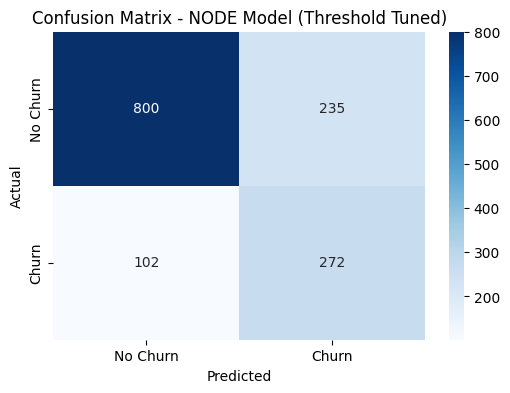

In [24]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - NODE Model (Threshold Tuned)")
plt.show()

In [25]:
auc = roc_auc_score(y_true, y_prob)
print("ROC-AUC Score:", auc)

ROC-AUC Score: 0.8410059676044331


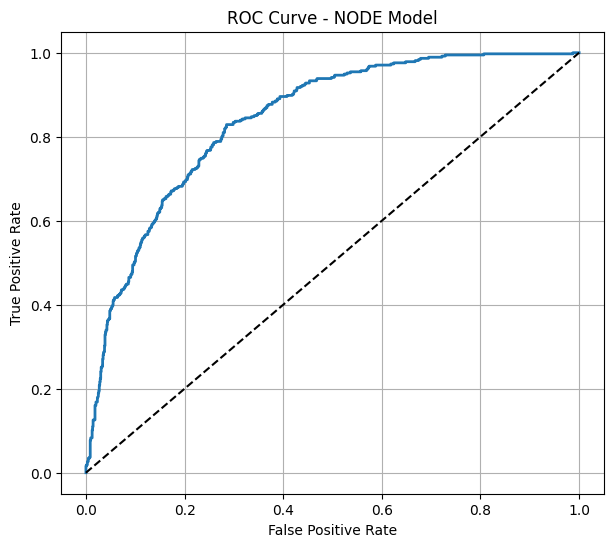

In [26]:
# compute ROC curve points
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

# plot ROC
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], "k--")   # diagonal baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - NODE Model")
plt.grid(True)
plt.show()

In [27]:
!cp -r /content/node_best_bayes_model /content/drive/MyDrive/Modals_Weight/node_best_bayes_model

In [28]:
from sklearn.metrics import recall_score

pred_train = final_model.predict(train_df)
pred_val = final_model.predict(val_df)

train_rec = recall_score(train_df["Churn"], pred_train["Churn_prediction"], pos_label=1)
val_rec   = recall_score(val_df["Churn"], pred_val["Churn_prediction"], pos_label=1)

print("Train Recall:", train_rec)
print("Val Recall:", val_rec)
print("Gap:", train_rec - val_rec)

Train Recall: 0.8118729096989966
Val Recall: 0.8127090301003345
Gap: -0.0008361204013378476
